In [1]:
# http://economics.fundamentalfinance.com/game-theory/nash-equilibrium.php

In [2]:
from random import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from math import sqrt
from collections import Counter

# Helper functions

In [3]:
class Game:
    def __init__(self, action_list, cost_list):
        self.cost_list = cost_list
        self.initialize_actions(action_list)
        self.initialize_weights()
        all_strategy = list(product(*action_list))
        self.initialize_actions_cost(all_strategy)

    def initialize_weights(self):
        agent_weights = {}
        for agent_name, strategy in self.agent_actions_dict.items():
            # Cannot start with 1, 1 ,1 weight, otherwise it will get stuck in the MNE immediately
            agent_weights[agent_name] = np.ones(len(strategy)) + np.random.normal(0, 0.1, size=len(strategy))
        self.agent_weights = agent_weights

    def initialize_actions(self, agent_actions_list):
        agent_actions = {}
        for i, actions in enumerate(agent_actions_list, start=1):
            agent_actions['agent{}'.format(i)] = actions
        self.agent_actions_dict =  agent_actions

    def initialize_actions_cost(self, all_strategy):
        """cost_list should be input row by row"""
        flat_cost_list = [item for sublist in self.cost_list for item in sublist]
        self.action_to_cost =  dict(zip(all_strategy, flat_cost_list))

    def action(self, probability_distribution):
        return np.random.choice(len(probability_distribution),1,p=probability_distribution)[0] # [0] unwarp the array

    def get_action(self, agent):
        total = sum(self.agent_weights[agent])
        num_actions = len(self.agent_weights[agent])
        agent_p = [self.agent_weights[agent][i] / total for i in range(num_actions)]
        agent_a = self.action(agent_p)
        return agent_a, agent_p

    def get_expected_cost_vector(self, agent, opponent_p):
        num_actions = len(self.agent_actions_dict[agent])
        action_vector = [[self.get_agent_actions(agent, (i, j)) for j in range(num_actions)] for i in range(num_actions)]
        agent_index = int(agent[-1]) - 1
        action_vector = np.array([list(map(self.action_to_cost.get, a)) for a in action_vector])[:,:,agent_index]
        cost_vector = np.sum(action_vector * opponent_p, axis=1)
        return cost_vector

    def get_cost_vector(self, agent, opponent_action):
        num_actions = len(self.agent_actions_dict[agent])
        action_vector = [self.get_agent_actions(agent, (i, opponent_action)) for i in range(num_actions)]
        agent_index = int(agent[-1]) - 1
        cost_vector = [self.action_to_cost[a][agent_index] for a in action_vector]
        return np.array(cost_vector)

    def get_agent_actions(self, agent, ij):
        if agent == 'agent1': i, j = ij
        else: j, i = ij
        return self.agent_actions_dict['agent1'][i], self.agent_actions_dict['agent2'][j]

    def MWU(self, iterations, epsilon=0.05, new_ep=lambda ep, t: ep, reset_cond=lambda t: False):
        assert(0 < epsilon < 1)
        num_actions = len(self.agent_weights['agent1'])

        agent_sums = {agent : sum(weights) for agent, weights in self.agent_weights.items()}

        def init_history(j):
            first = [self.agent_weights['agent{}'.format(j+1)][i] / agent_sums['agent{}'.format(j+1)] for i in range(num_actions)]
            return [first]
        self.agent_histories = [init_history(j) for j in range(2)]
        self.cost_histories = [[], []]
        self.action_histories = [[], []]

        self.total_regret = [0, 0]
        self.regret_histories = [[], []]
        NUM_AGENTS = 2

        def best_decision_cost(other_player_action_history):
            def cycle(a):
                return a % 3

            def beats(a):
                return cycle(a+1)

            def losesto(a):
                return cycle(a-1)

            count = Counter(other_player_action_history)
            target = count.most_common(1)[0][0]
            return count[beats(target)] - count[losesto(target)]

        def cost(a1, a2):
            return self.get_cost_vector('agent1', a2)[a1]

        for t in range(1, iterations + 1):
            if reset_cond(t):
                epsilon = new_ep(epsilon, t)
                if epsilon <= 0: epsilon = 0.01
                elif epsilon >= 1: epsilon = 0.99
            ap = [self.get_action('agent{}'.format(j+1)) for j in range(NUM_AGENTS)]
            agents_a, agents_p = zip(*ap)
            expected_cost_vectors = tuple(self.get_expected_cost_vector('agent{}'.format(j+1), agents_p[1-j]) for j in range(NUM_AGENTS))
            cost_vectors = tuple(self.get_cost_vector('agent{}'.format(j+1), agents_a[1-j]) for j in range(NUM_AGENTS))

            for agent_index in range(NUM_AGENTS):
                self.action_histories[agent_index].append(agents_a[agent_index])

            for agent_index in range(NUM_AGENTS):
                self.agent_weights['agent{}'.format(agent_index+1)] *= (1 - epsilon)**expected_cost_vectors[agent_index]
                agent_sums = {agent : sum(weights) for agent, weights in self.agent_weights.items()}
                self.agent_histories[agent_index].append([self.agent_weights['agent{}'.format(agent_index+1)][i] / agent_sums['agent{}'.format(agent_index+1)] for i in range(num_actions)])
                self.total_regret[agent_index] = sum(map(cost, *self.action_histories)) - best_decision_cost(self.action_histories[1-agent_index])
                self.regret_histories[agent_index].append(self.total_regret[agent_index] / t)

    def plot(self):
        fontsize = 16
        fontsize_title = 20
        fig, ax = plt.subplots(2, 2, sharex=True, figsize=(16,8))
        ax[0,0].set_title('Probability of choices')
        ax[0,0].set_ylabel('Agent 1')
        ax[1,0].set_ylabel('Agent 2')
        ax[1,0].set_xlabel('Step')
        ax[0,1].set_title('Regret')
        ax[1,1].set_xlabel('Step')
        agent_histories = [[[], [], []], [[], [], []]]
        for i, agent in enumerate(self.agent_histories):
            for item in agent:
                for j in range(3):
                    agent_histories[i][j].append(item[j])
        for i in range(2):
            for line, label in zip(agent_histories[i], 'RPS'):
                ax[i,0].plot(line, label=label)
                ax[i,0].legend()
            for i, line in enumerate(self.regret_histories):
                ax[i,1].plot(line, 'b')
                ax[i,1].plot(np.zeros(len(self.regret_histories[i])), 'r')

    def plot_scatter(self):
            plt.figure(figsize=(8,8))
            plt.scatter(np.array(self.agent1_history)[:,0], np.array(self.agent2_history)[:,0])
            plt.xlim(0, 1)
            plt.ylim(0, 1)

## Multiplicative Weight Update Algorithm

$$\huge w^{t+1}(a) = w^t(a)(1-\epsilon)^{c^t(a)}$$

Starting simulation, this may take a while...
10 iterations with 𝜖 = 0.01


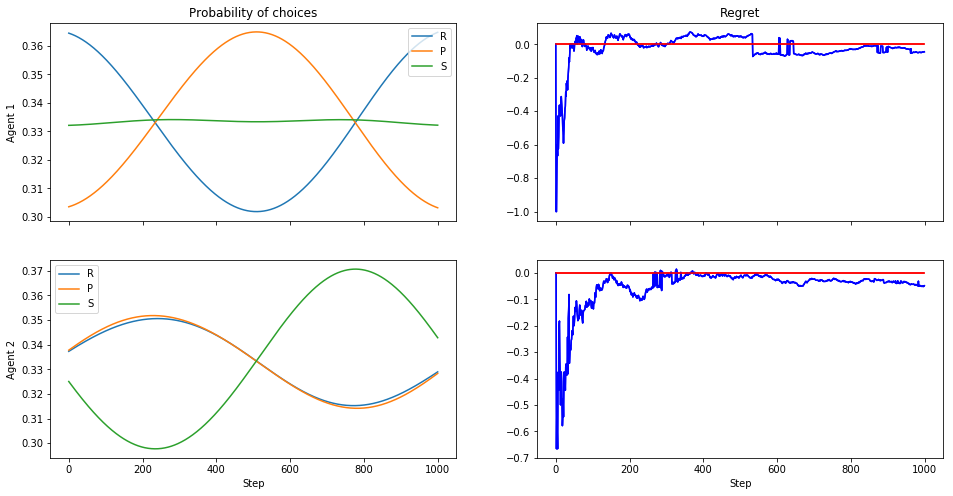

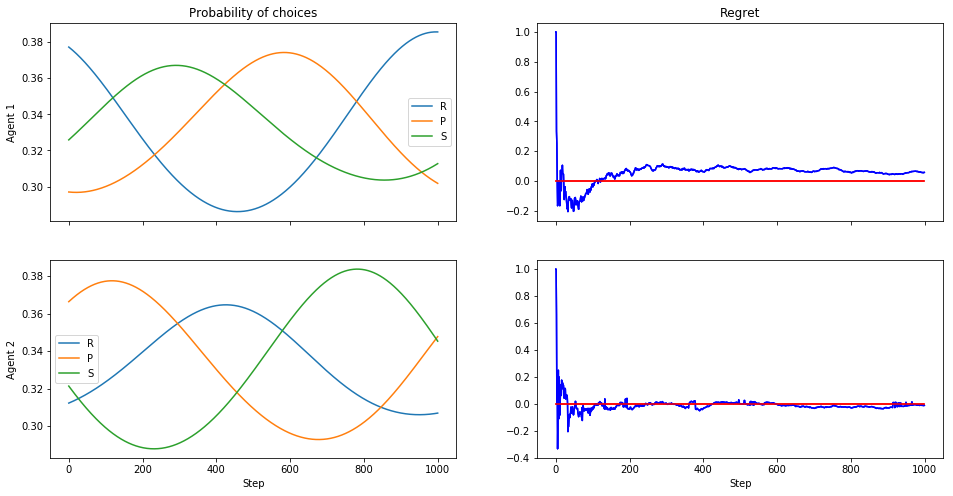

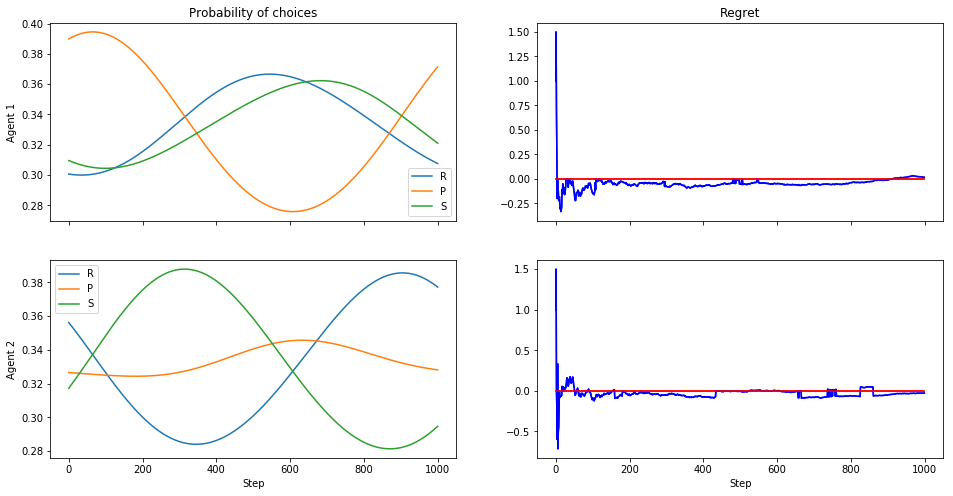

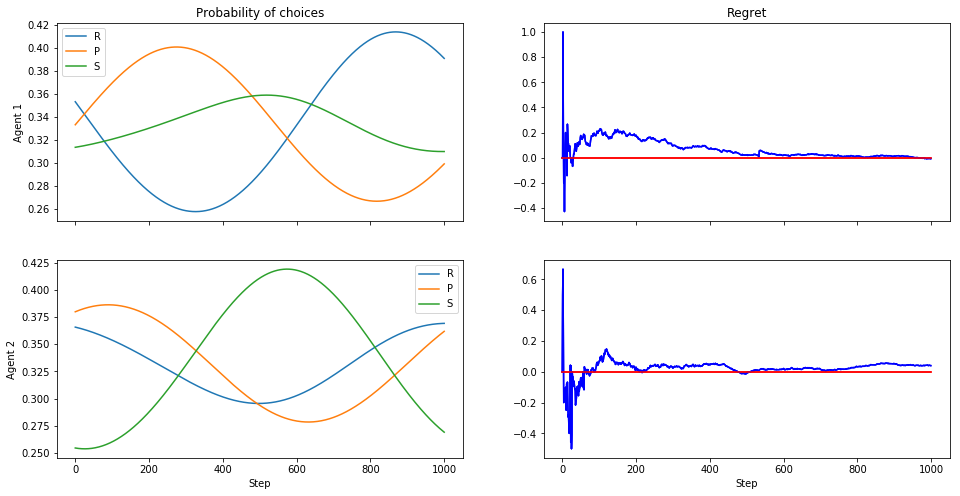

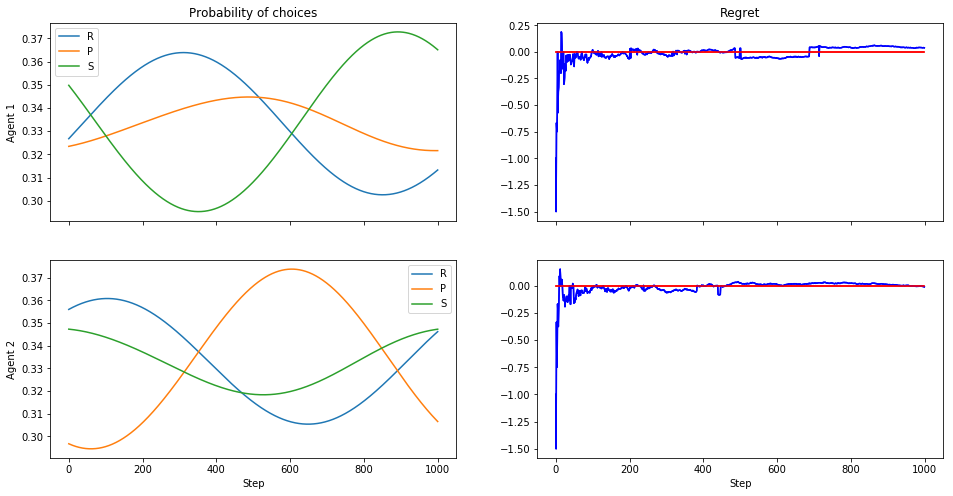

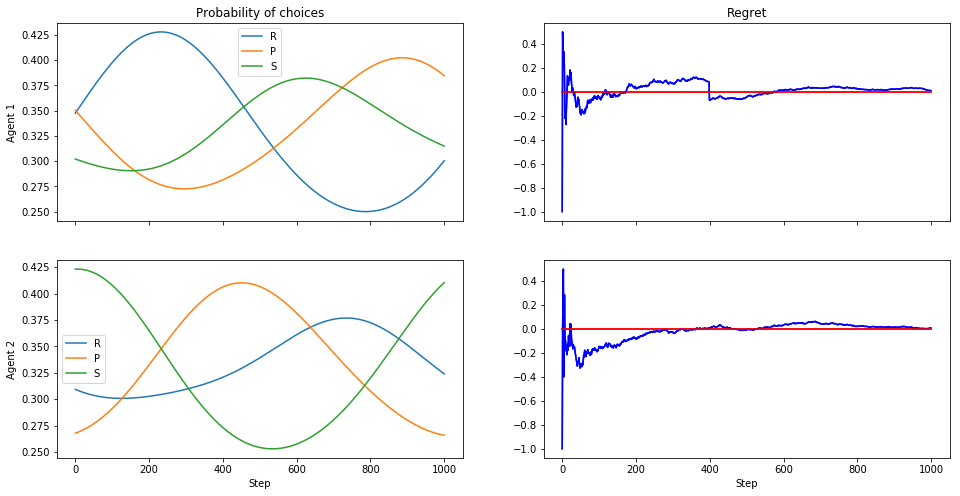

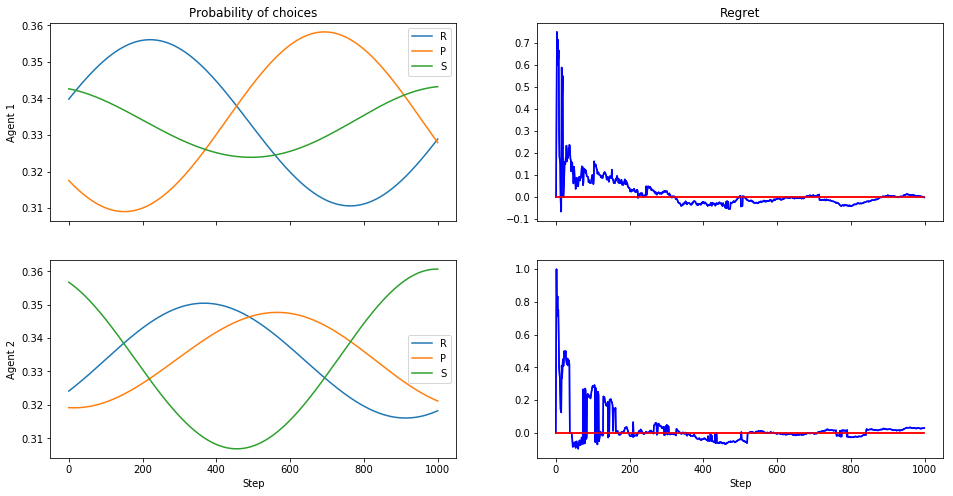

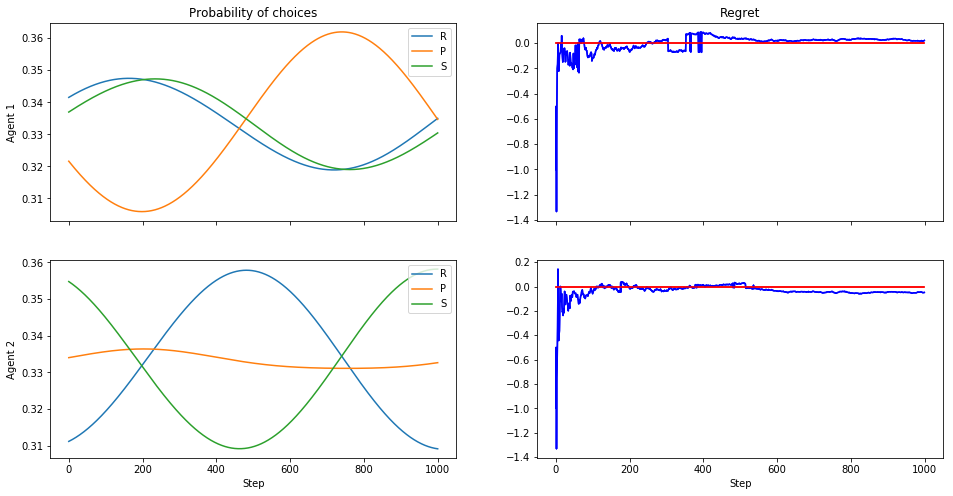

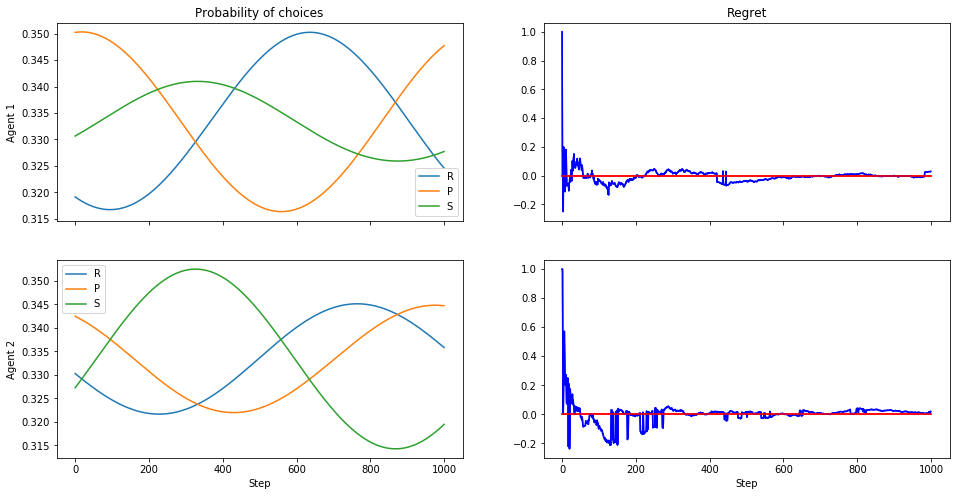

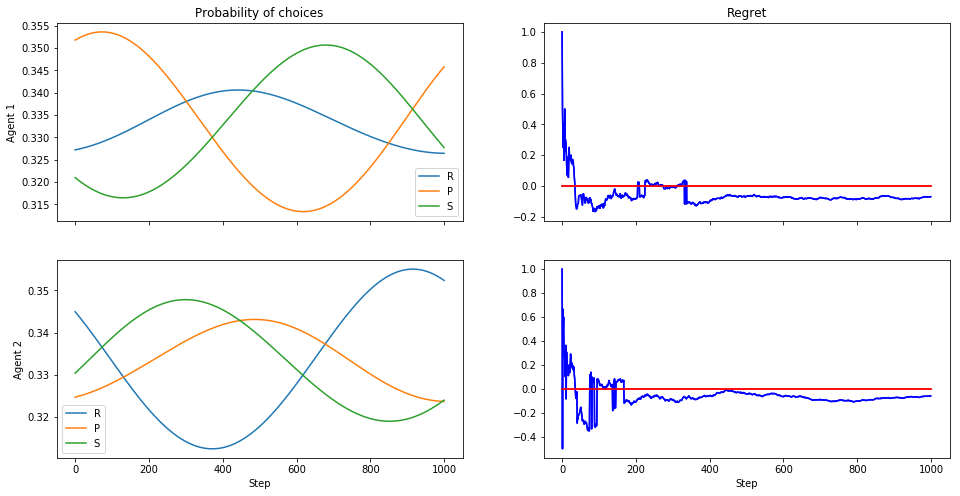

In [4]:
action_list = [['Rock', 'Paper', 'Scissor'],
               ['Rock', 'Paper', 'Scissor']]
cost_list = [[[0,0],[1,-1],[-1,1]],
             [[-1,1],[0,0],[1,-1]],
             [[1,-1],[-1,1],[0,0]]]
RPS = Game(action_list, cost_list)

print('Starting simulation, this may take a while...')

print('10 iterations with 𝜖 = 0.01')
for i in range(10):
    RPS.initialize_weights()
    RPS.MWU(1000, 0.01)
    RPS.plot()

10 iterations with 𝜖 = 1/√t


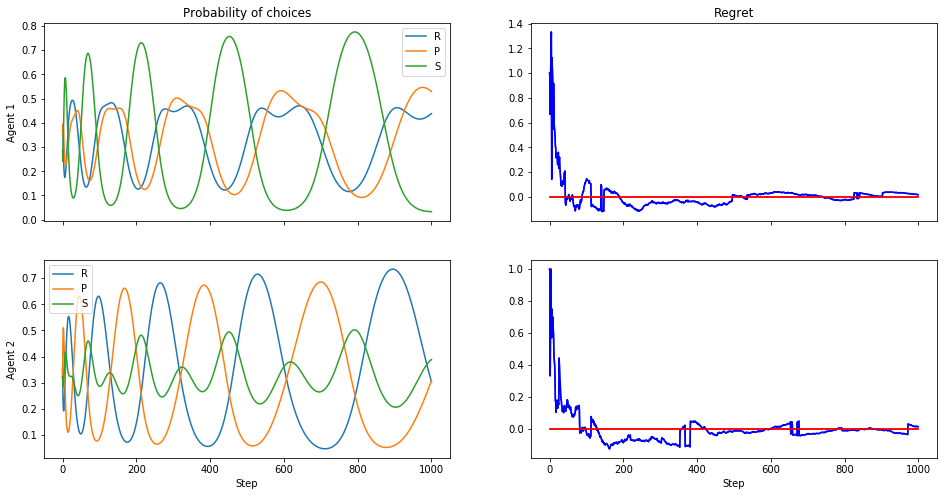

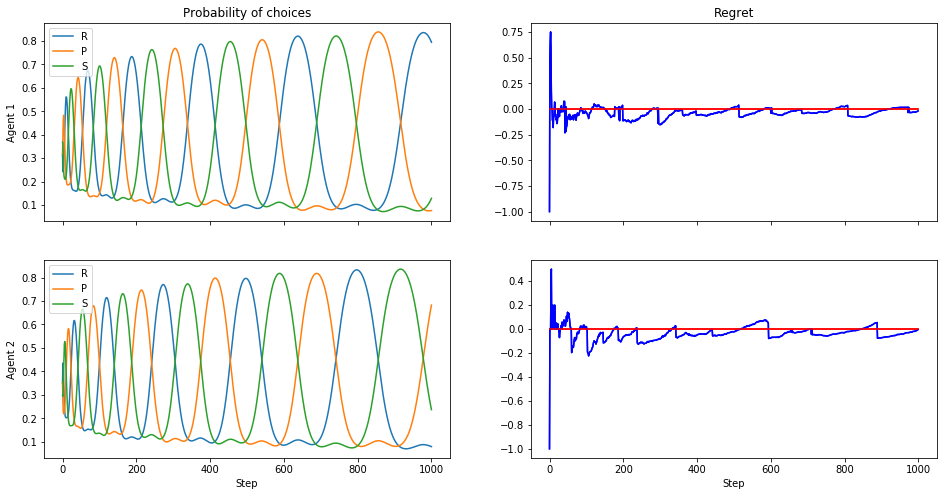

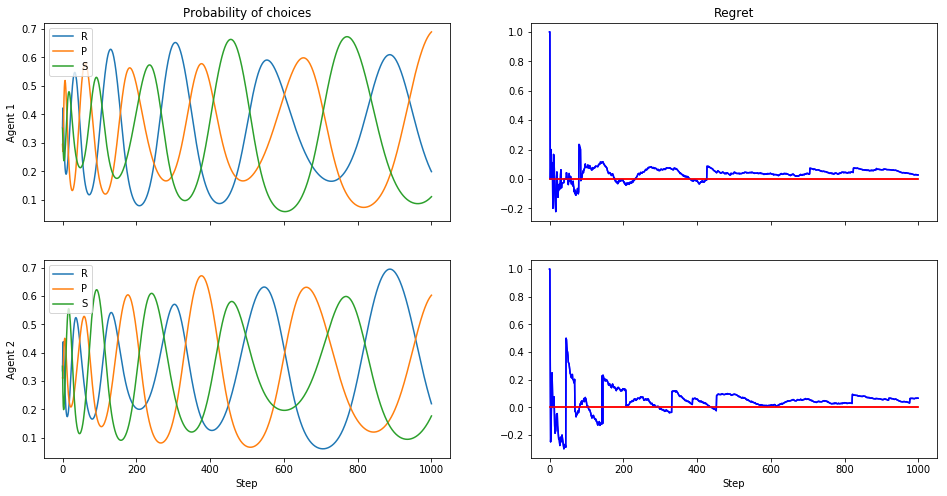

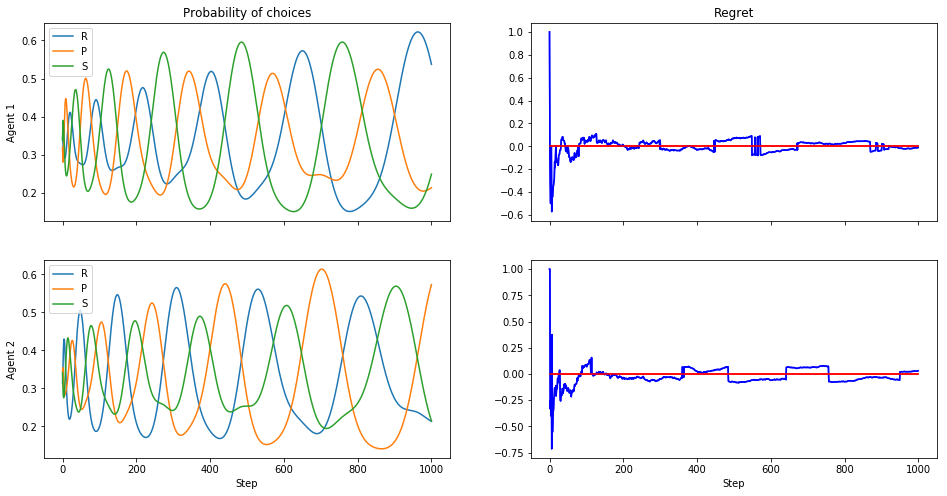

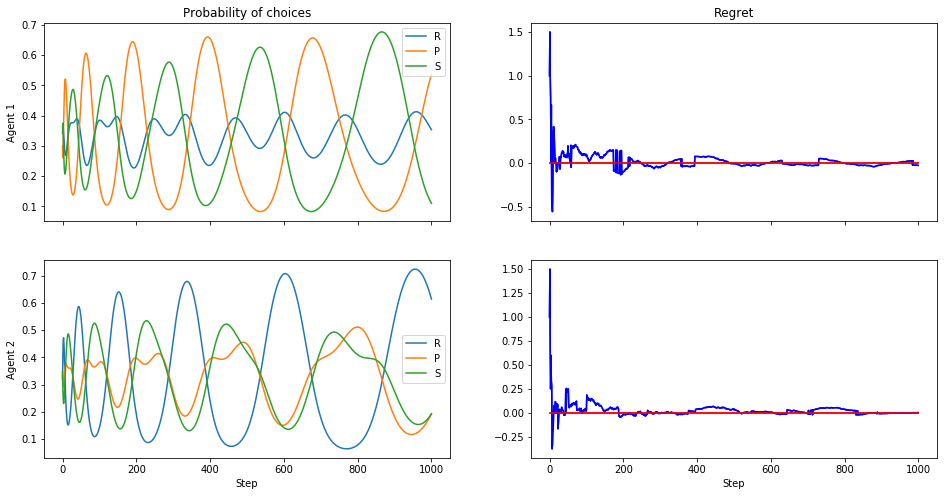

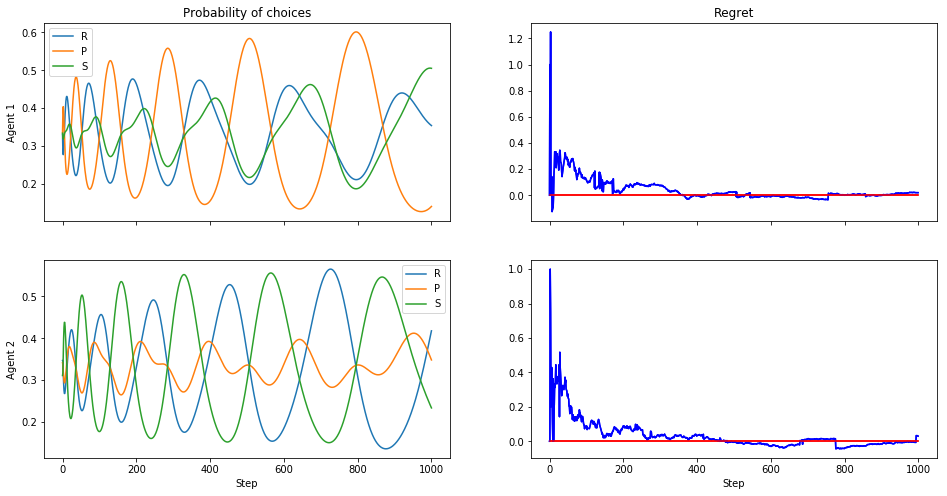

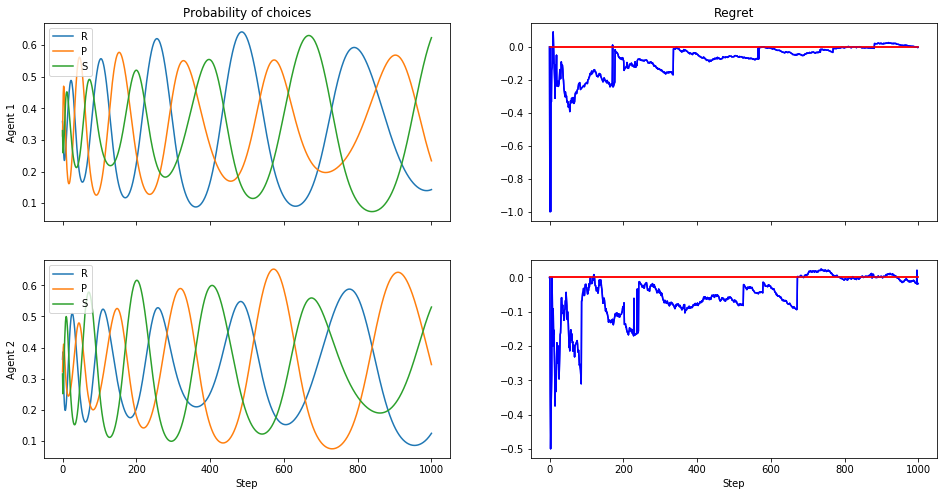

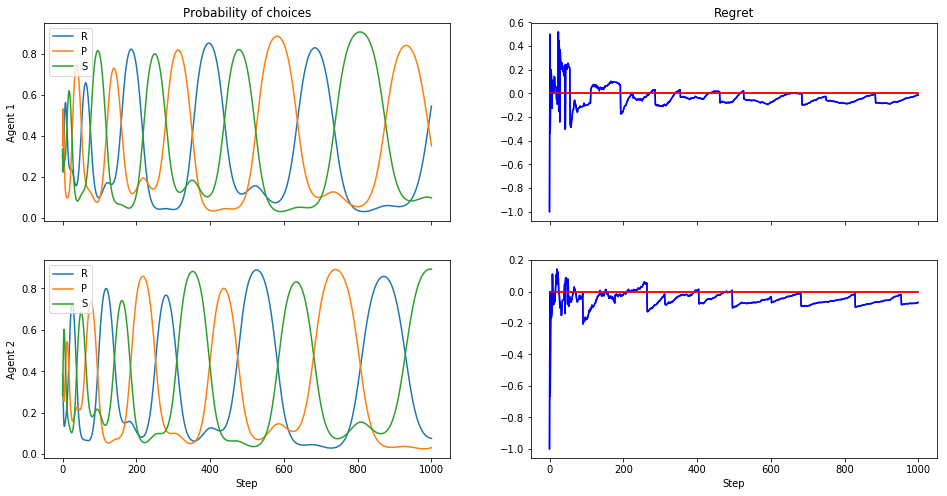

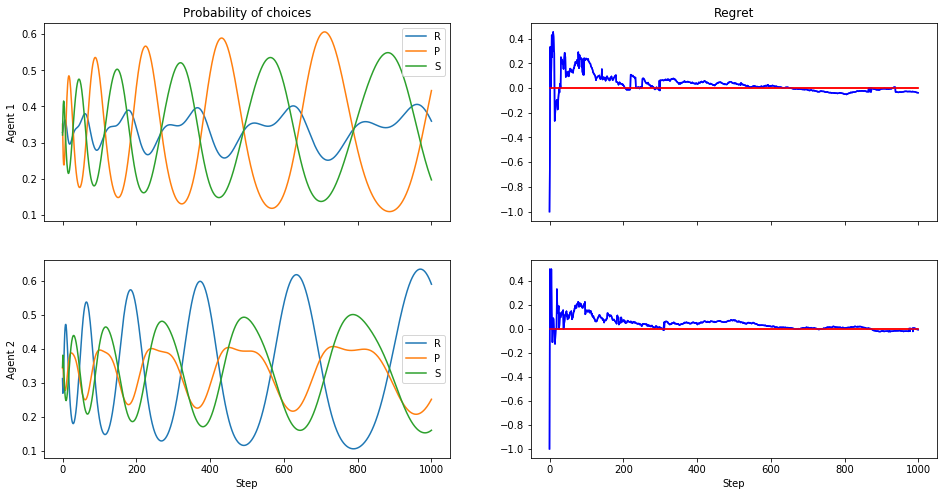

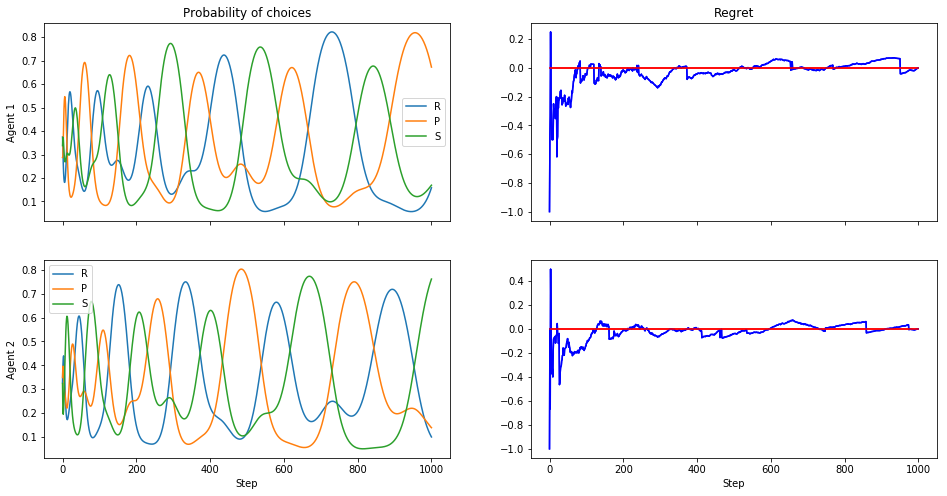

In [5]:
print('10 iterations with 𝜖 = 1/√t')
for i in range(10):
    RPS.initialize_weights()
    RPS.MWU(1000, new_ep=lambda ep, t: 1/sqrt(t), reset_cond=lambda t: True)
    RPS.plot()